<div align="center">
<h1 style="font-weight:bold; font-size:24px; color: #004d44; margin-bottom: 5;">Identifying Cyclist Safety in Urban Traffic</h1>
<h1 style="font-weight:bold; font-size:24px; color: #004d44; margin-top: 8px;">Using Computer Vision</h1>
<br>
<p style="font-size:18px; font-weight:bold; margin: 10;">Joelma Rodrigues</p>
<p style="font-size:18px; margin: 10;">B.Sc. in Computing & IT (4ᵗʰ year)</p>
<p style="font-size:18px; margin: 0;">CCT College Dublin</p>
<br>
<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.cct.ie%2Fwp-content%2Fuploads%2FCCT_Logo_New_Aug_17-2.jpg&f=1&nofb=1&ipt=86bc4d018505dabaf623bb8b28495f926a4cb4ed2cb2ef7cc51583ac6630d2fa" width="450" alt="CCT College Dublin Logo"/>
<br>
<p style="font-size:18px; margin: 5;">May 2025</p>
<p style="font-size:18px; margin: 0;">Supervisor: Dr. Muhammad Iqbal</p>
</div>

<h2 style="color: #026658; font-size: 32px; font-weight:bold;">Part I</h2>

<h2 style="color: #026658;font-size: 32px;">Install Libraries</h2>

In [5]:
# install libraries
#!pip install numpy==1.26.4 opencv-python pillow matplotlib seaborn albumentations

In [1]:
# ============== General Utilities ==========                                            Sources
import os                                # Work with folders and file paths              https://docs.python.org/3/library/os.html
import random                            # Pick random items (like images or values)     https://docs.python.org/3/library/random.html
from collections import Counter          # Count elements                                https://docs.python.org/3/library/collections.html#collections.Counter

# =============== Visualisation =============
import matplotlib.pyplot as plt          # Create simple plots                           https://matplotlib.org/
import seaborn as sns                    # Prettier charts                               https://seaborn.pydata.org/
import cv2                               # Image processing                              https://docs.opencv.org/
import PIL.Image                         # Image processing                              https://pillow.readthedocs.io/en/stable/
from IPython.core.display import Image   # Display images in Jupyter                     https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html

# =============== Augmentation  =============
import albumentations as A               # Image augmentations                           https://albumentations.ai/
import numpy as np                       # Handle arrays                                 https://numpy.org/

<h1 style="color: #044b42; font-size: 36px; font-weight:bold;">Data Understanding</h1>
<div style="margin: 0 auto; color: #333;">
    <h2 style="color: #026658; font-size: 32px">Data Collection</h2>
    <p style="font-size: 16px;">
        The images used in this project were collected from two open-source computer vision datasets. The classes selected for model training are listed below:
    </p>
    <ul style="font-size: 16px;">
        <li>
            <strong>Open Images Dataset V7</strong> <br>
            <ul>
                <li><strong>Bicycle:</strong> 17,631 images</li>
                <li><strong>Helmet:</strong> 12,614 images</li>
            </ul>
            <span style="font-size: 15px;">Open Images is a Google dataset containing over 1.9 million images with 600 annotated object classes (Open Images Dataset, 2022).</span>
        </li>
        <br>
        <li>
            <strong>Roboflow</strong> <br>
            <ul>
                <li><strong>Scooter:</strong> 14,101 images</li>
                <li><strong>Vest:</strong> 17,761 images</li>
            </ul>
            <span style="font-size: 15px;">Roboflow is a platform for training and deploying computer vision models, offering access to over 750,000 datasets (Roboflow, 2020).</span>
        </li>
    </ul>
</div>

<h2 style="color: #026658;font-size: 32px;">Classes distribution</h2>

In [3]:
# Create variables for the dataset
base_path = 'datasets/ciclovia-yolo'  # base folder where is the yolo dataset
splits = ['train', 'val', 'test']     # folders of split data

In [4]:
# Counts how many times each class appear
count_total = Counter()

# Go inside every folder (train, val, test) = splits
for split in splits:
    path = os.path.join(base_path, split, 'labels')      # build path to labels folder
    for f in os.listdir(path):                           # loop through all the files in that folder
        if f.endswith('.txt'):                           # only .txt files
            for line in open(os.path.join(path, f)):     # open each file and read line by line
                count_total[line.split()[0]] += 1        # count labels using the class index (string)

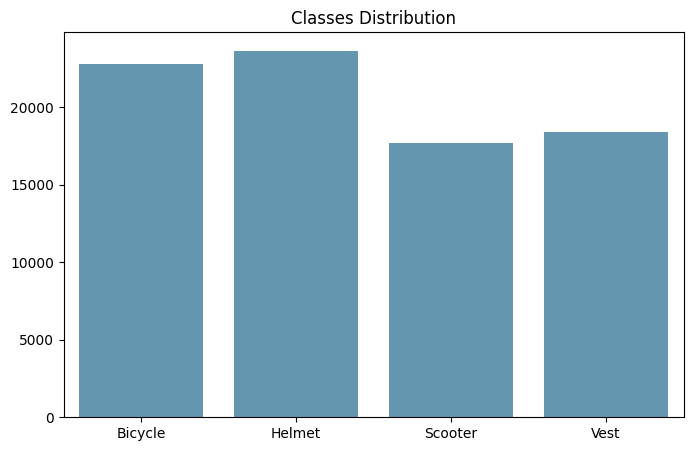

In [5]:
# Organize the counts into a dictionary to use in x-axis and y-axis
labels = ['Bicycle', 'Helmet', 'Scooter', 'Vest']                                   #classes names in order
counts = [count_total['0'], count_total['1'], count_total['2'], count_total['3']]   # count each class individually

# Graph to show class distribution
plt.figure(figsize=(8, 5))                        # size of the figure
sns.barplot(x=labels, y=counts, color='#579bbc')  # plot bars with class counts
plt.title("Classes Distribution")                 # add title
plt.show()                                        # show the plot

In [10]:
# Using zip() to relate the labels with its counts
for label, count in zip(labels, counts):
    print(f"{label}: {count}")

Bicycle: 22771
Helmet: 23666
Scooter: 17701
Vest: 18398


<div style="font-size: 16px;">
    <h3 style="font-size:18px;  color: #026658;"><strong>Observations</strong></h3>
    <p>The initial dataset collected contained approximately 62,107 annotated images, totaling around 12GB of data including the labels.
    <br>Although there is a modest imbalance in the representation of the 'Scooter' and 'Vest' classes, initial modeling phases showed that the model learned these classes more easily than 'Helmet' and 'Bicycle'. 
    <br>This is likely due to the object sizes and, in the case of bicycles, the irregular geometry and empty spaces between the frame and wheels. </p>
</div>

<h2 style="color: #026658; font-size: 26px;">Sample of the dataset</h2>

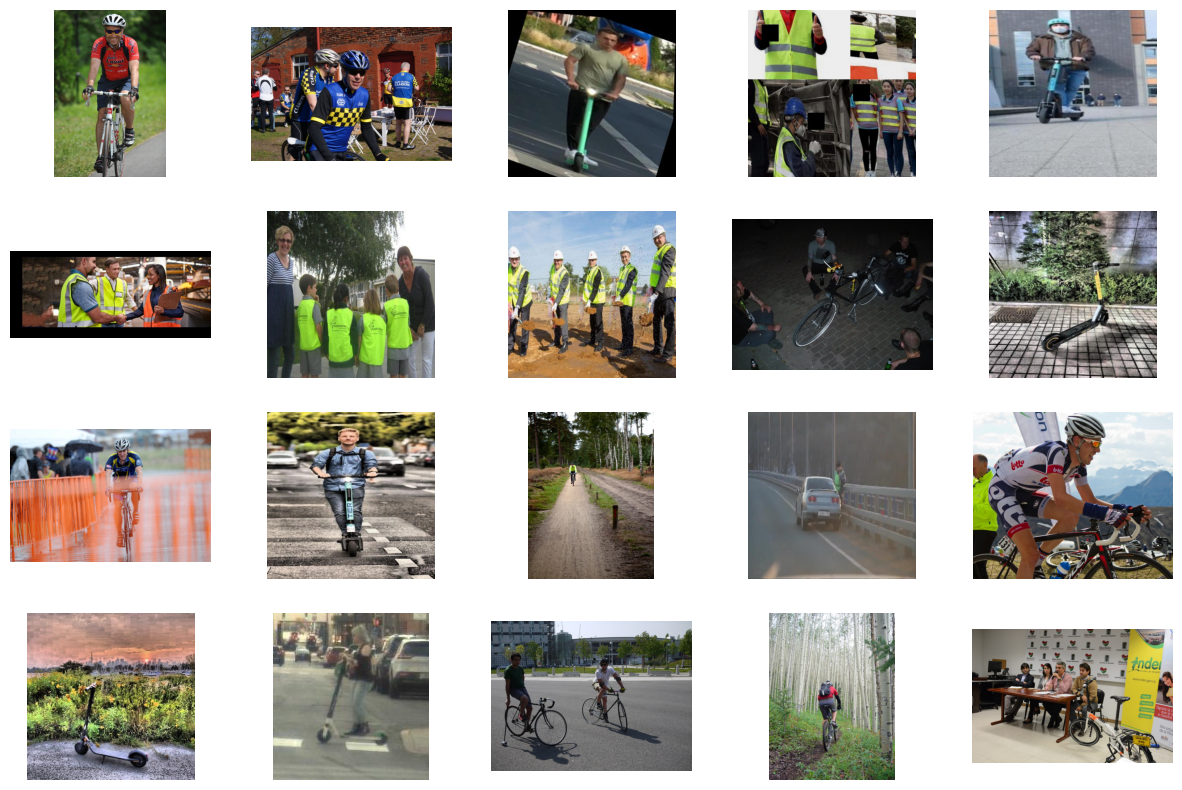

In [11]:
random.seed(13)                                                     # ensure always show the same images
img_dir = os.path.join(base_path, 'train', 'images')                # path to the folder with images (train split)
files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]      # get all .jpg files in that folder
sample = random.sample(files, 20)                                   # select 20 random images from the list

plt.figure(figsize=(15, 10))                                        # create the plot include the size

# iterate over the images: loop through the list of files
for i, f in enumerate(sample):
    # read images and convert BGR to RGB: using OpenCV (cvtColor and COLOR_BGR2RGB)
    img = cv2.cvtColor(cv2.imread(os.path.join(img_dir, f)), cv2.COLOR_BGR2RGB)
    
    # create a subplot (4 rows, 5 columns, position i+1)
    plt.subplot(4, 5, i+1)                            # 4 rows, 5 columns 
    plt.imshow(img)                                   # show the image
    plt.axis('off')                                   # remove the axis (clean)
    
# Show all the images beside each other
plt.show()

<div style="font-size: 16px;">
    <h3 style="font-size:18px;  color: #026658;"><strong>Observations</strong></h3>
    <ul>
        <li>The 'Helmet' class might include helmets that are not specifically for cyclists; however, some scooter riders use motorcycle helmets.</li>
        <li>The 'Bicycle' class is complete, with a large number of images available.</li>
        <li><strong>It was hard to find images for the 'high visibility vest' class.</strong> The majority of 'hi-vis' images are from construction environments and different public repositories, requiring the merging of more than three datasets to reach a reasonable amount of images.</li>
        <li><strong>The dataset is not perfect and may contain some issues:</strong>
            <ul>
                <li>There are images from the 90s, in different sizes, and some bounding boxes are too small.</li>
                <li>Some images gathered from Roboflow are frames extracted from videos.</li>
                <li>These issues will be addressed during the Data Preparation Phase.</li>
            </ul>
        </li>
        <li>Time constraints affected the quality of the dataset, as I had to trust that a third party labelled the images properly.</li>
    </ul>
</div>

<h1 style="color: #044b42; font-size: 36px; font-weight:bold;">Data Preparation</h1>

<h2 style="color: #026658; font-size: 32px">Data Split</h2>
<p style="font-size: 16px;"> The final dataset contained a total of <strong>40157 images</strong>. A common division ratio was applied: <strong>80/10/10 ratio</strong>. 
<br>Most images are intended for the training the model, where the model learns the most important characteristics of the relevant classes, while the validation set is a smaller subset that helps the model evaluate how it is doing during the training section on unseen images. Finally, the test set serves the purpose of assessing the model.
<br>(Géron, 2019)</p>


In [12]:
# Count images in each split folder (os)
image_counts = {}
for split in splits:
    image_dir = os.path.join(base_path, split, 'images')     # path to images (defined)
    count = len([f for f in os.listdir(image_dir)            # count only .jpg files
                 if f.endswith(('.jpg'))])
    image_counts[split] = count                              # store count per split

# Calculate total number of images
total_images = sum(image_counts.values())          # train + val + test

# Calculate percentage per split
train_set = image_counts['train'] / total_images   # train percentage
val_set = image_counts['val'] / total_images       # validation percentage
test_set = image_counts['test'] / total_images     # test percentage

# Print results
print("Image count:", image_counts)     # image count per split
print("Total:", total_images)           # total number of images
print(f"Train: {train_set:.2%} | Val: {val_set:.2%} | Test: {test_set:.2%}")  # display percentages with 2 decimals after 

Image count: {'train': 32121, 'val': 4015, 'test': 4021}
Total: 40157
Train: 79.99% | Val: 10.00% | Test: 10.01%


<h2 style="color: #044b42; padding-bottom: 5px; font-size: 32px;">Data Augmentation</h2>
<p style="font-size: 16px;"><strong><a href="https://albumentations.ai/docs/api-reference/albumentations/augmentations/geometric/functional/#resize" target="_blank">Resize</a></strong> – Resize all images to 640×640.</p>

<p style="font-size: 16px;"><strong><a href="https://albumentations.ai/docs/api-reference/albumentations/augmentations/geometric/flip/#HorizontalFlip" target="_blank">Horizontal Flip</a></strong> – Flips image left to right.</p>

<p style="font-size: 16px;"><strong><a href="https://albumentations.ai/docs/api-reference/albumentations/augmentations/geometric/transforms/#Affine" target="_blank">Translation</a></strong> – Moves image slightly up/down/left/right.</p>

<p style="font-size: 16px;"><strong><a href="https://albumentations.ai/docs/api-reference/albumentations/augmentations/pixel/transforms/#HueSaturationValue" target="_blank">HSV Shift</a></strong> – Changes brightness, hue, saturation.</p>

<p style="font-size: 16px;"><strong><a href="https://albumentations.ai/docs/api-reference/albumentations/augmentations/dropout/coarse_dropout/#CoarseDropout" target="_blank">Erasing (CoarseDropout)</a></strong> – Hides random parts to simulate occlusion.</p>

<p style="font-size: 16px;"> (Buslaev et al., 2020)</p>

In [13]:
# Demonstration
# Load image and convert to RGB
image = np.array(PIL.Image.open('datasets/ciclovia-yolo/train/images/0-bicycle_bicycle_3184.jpg').convert('RGB'))  # Open original image

# Resize image to 640x640 (model input size)
resized = A.Resize(640, 640)(image=image)['image']  # Apply resize once

# Define augmentations to apply on resized image
augmentations = {
    "Original": image,                            # Unchanged image
    "Resized (640x640)": resized,                 # Resized image for model
    "Horizontal Flip": A.HorizontalFlip(p=1.0),   # Horizontal mirror
    "Translation": A.Affine(                      # Image shift
        translate_percent=0.15,
        scale=1.0,
        rotate=0, p=1.0
    ),
    "HSV Shift": A.HueSaturationValue(        # Colour variation
        hue_shift_limit=15,                   # Change hue slightly
        sat_shift_limit=178,                  # Change saturation strongly
        val_shift_limit=102,                  # Change brightness
        p=1.0
    ),
    "Erasing": A.CoarseDropout(p=0.9)         # Simulated occlusion
}

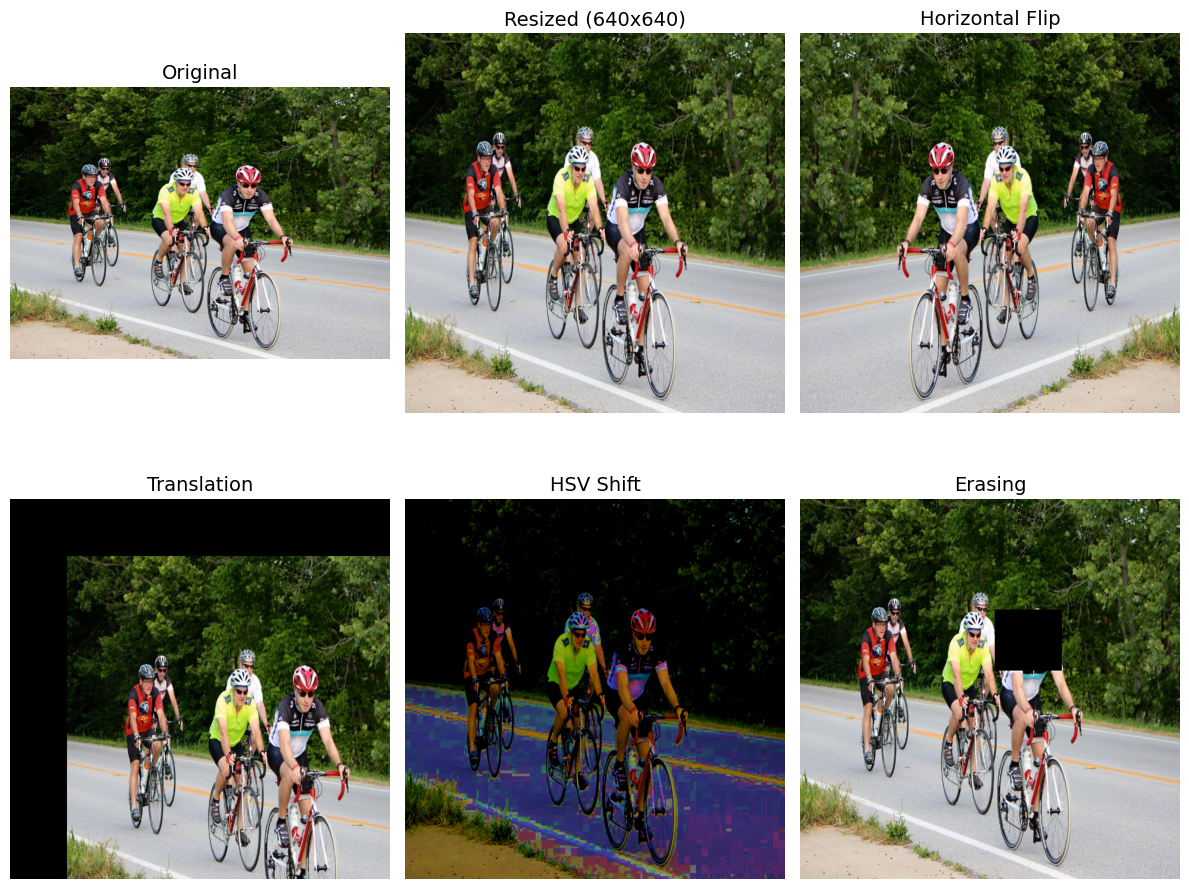

In [14]:
# Apply each augmentation to the resized image
results = {
    k: v if isinstance(v, np.ndarray) else v(image=resized)['image']
    for k, v in augmentations.items()
}

# Plot results in a 2x3 grid -> fig is the bigger chart where the axes with fit the subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
for ax, (title, img) in zip(axes.flat, results.items()):
    ax.imshow(img)                  # Show image
    ax.set_title(title, fontsize=14)
    ax.axis("off")                 # Hide axes

plt.tight_layout()
plt.show()

<div style="font-size: 16px;">
    <h3 style="font-size:18px;  color: #026658;"><strong>Observation</strong></h3>
    <p>
        This is just an example of augmentation's techniques using Albumentations. Online augmentation, which is better when you have too many images, opposite to Offline, which is when you apply before the training and generates versions of you original image then train it (Buslaev et al., 2020). 
        <br> In this case, train set has 30k+ after 1 o each 5 augmentations 30 000 \* 5 = 150 000 image, there isn't enough storage. So I used online which is applied during the training.
    </p>